<a href="https://colab.research.google.com/github/YairYarden/DeepCascadingAMC/blob/feature%2Fdivide_between_qams/Ex1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mount Google Drive

In [5]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


# Chose Device

In [12]:
# check if CUDA is available
import torch
is_gpu_available = torch.cuda.is_available()

if not is_gpu_available:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

CUDA is not available.  Training on CPU ...


# Load Python Files

In [10]:
# Load files 
from google.colab import files

# Dataset Classes
!cp /content/drive/MyDrive/Deep_learning_05107255/project/code/AMC_classes/data/encoder.py /content
!cp /content/drive/MyDrive/Deep_learning_05107255/project/code/AMC_classes/data/dataset.py /content
!cp /content/drive/MyDrive/Deep_learning_05107255/project/code/AMC_classes/data/dataset_builder.py /content
!cp /content/drive/MyDrive/Deep_learning_05107255/project/code/AMC_classes/data/rml_2016.py /content
!cp /content/drive/MyDrive/Deep_learning_05107255/project/code/AMC_classes/data/RML2016_SNR_groups_DataLoader.py /content
!cp /content/drive/MyDrive/Deep_learning_05107255/project/code/AMC_classes/data/RML2016_QAMs_Snrs_Groups_DataLoader.py /content
!cp /content/drive/MyDrive/Deep_learning_05107255/project/code/AMC_classes/data/RML2016_MergedQAMs_DataLoader.py /content
!cp /content/drive/MyDrive/Deep_learning_05107255/project/code/AMC_classes/data/RML2016_QAMs_AmpPhase.py /content

!cp /content/drive/MyDrive/Deep_learning_05107255/project/code/AMC_classes/data/snr_encoder.py /content

# Utils Classes
!cp /content/drive/MyDrive/Deep_learning_05107255/project/code/AMC_classes/utils/plot.py /content

# Training Classes
!cp /content/drive/MyDrive/Deep_learning_05107255/project/code/AMC_classes/training/accuracy.py /content
!cp /content/drive/MyDrive/Deep_learning_05107255/project/code/AMC_classes/training/confusion.py /content
!cp /content/drive/MyDrive/Deep_learning_05107255/project/code/AMC_classes/training/baseModel.py /content
!cp /content/drive/MyDrive/Deep_learning_05107255/project/code/AMC_classes/training/cldnn.py /content
!cp /content/drive/MyDrive/Deep_learning_05107255/project/code/AMC_classes/training/flatten.py /content



# Import Functions & Classes

In [11]:
# Plotting Includes
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

# External Includes
import numpy as np
from pprint import pprint

from torch.autograd import Variable
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader

# Internal Includes
# Data
from dataset import Dataset
from encoder import Encoder
from rml_2016 import load_RML201610B_dataset
from RML2016_SNR_groups_DataLoader import load_RML201610B_dividedBySNR
from RML2016_QAMs_Snrs_Groups_DataLoader import load_RML201610B_onlyQAMs_dividedBySNR
from RML2016_QAMs_AmpPhase import load_RML201610B_onlyQAMs_AmpPhase_dividedSNR
from RML2016_MergedQAMs_DataLoader import load_RML201610B_MergedQAMs


from snr_encoder import SNREncoder

# Utils
from plot import plot_acc_vs_snr, plot_confusion, plot_convergence, plot_IQ

# Training
from accuracy import compute_accuracy, compute_accuracy_on_cross_sections
#from accuracy import compute_cascaded_sen_amc_accuracy
from confusion import compute_confusion
from baseModel import Model
from cldnn import CLDNN


# Load Dataset

## Load 

In [16]:
# Load
import os
drive_path = '/content/drive/MyDrive/Deep_learning_05107255/project'
data_path = os.path.join(drive_path, 'RadioML2016_b/RML2016.10b.dat')
# FULL Dataset
dataset = load_RML201610B_dataset(path=data_path)

# Print
print(len(dataset))
pprint(dataset.get_examples_per_class())

1200000
{'8PSK': 120000,
 'AM-DSB': 120000,
 'BPSK': 120000,
 'CPFSK': 120000,
 'GFSK': 120000,
 'PAM4': 120000,
 'QAM16': 120000,
 'QAM64': 120000,
 'QPSK': 120000,
 'WBFM': 120000}


In [17]:
# Dataset divided to 3 SNR Groups
datasetLow, dataMed, datasetHigh = load_RML201610B_dividedBySNR(path=data_path)
# datasetLowMergedQams, dataMedMergedQams, datasetHighMergedQams = load_RML201610B_MergedQAMs(path=data_path) # Merged QAMS
# -------------------------------------------------------------------------------------------------------- #
# Only QAMs divided to 3 SNR Groups
# I,Q
##datasetLowQams, dataMedQams, datasetHighQams = load_RML201610B_onlyQAMs_dividedBySNR(path=data_path)

# Amplitude & Phase
# datasetLowQams, dataMedQams, datasetHighQams = load_RML201610B_onlyQAMs_AmpPhase_dividedSNR(path=data_path)
# # -------------------------------------------------------------------------------------------------------- #
# # Print
# print('Num examples High SNR :', len(datasetHigh))
# print('Num examples Medium SNR :', len(dataMed))
# print('Num examples Low SNR :', len(datasetLow))
# print('High SNR per class examples :')
# pprint(datasetHigh.get_examples_per_class())

# # Print only QAMs
# print('High SNR QAMs examples per class : ')
# pprint(datasetHighQams.get_examples_per_class())



## Split to Train - Val - Test

In [18]:
# All together
# train, test = dataset.split(frac=0.3, on=["Modulation", "SNR"])
# train, val = train.split(frac=0.05, on=["Modulation", "SNR"])
# -----------------------------------------------------------------
# Splitted to SNR
# High
train_high_snr, test_high_snr = datasetHigh.split(frac=0.3, on=["Modulation", "SNR"])
train_high_snr, val_high_snr = train_high_snr.split(frac=0.05, on=["Modulation", "SNR"])
# # medium
train_med_snr, test_med_snr = dataMed.split(frac=0.3, on=["Modulation", "SNR"])
train_med_snr, val_med_snr = train_med_snr.split(frac=0.05, on=["Modulation", "SNR"])
# # low
train_low_snr, test_low_snr = datasetLow.split(frac=0.3, on=["Modulation", "SNR"])
train_low_snr, val_low_snr = train_low_snr.split(frac=0.05, on=["Modulation", "SNR"])
# # -----------------------------------------------------------------
# # Splitted QAMs to train & test
# train_Qams_high_snr, test_Qams_high_snr = datasetHighQams.split(frac=0.3, on=["Modulation", "SNR"])
# train_Qams_high_snr, val_Qams_high_snr = train_Qams_high_snr.split(frac=0.05, on=["Modulation", "SNR"])

# train_Qams_med_snr, test_Qams_med_snr = dataMedQams.split(frac=0.3, on=["Modulation", "SNR"])
# train_Qams_med_snr, val_Qams_med_snr = train_Qams_med_snr.split(frac=0.05, on=["Modulation", "SNR"])

# train_Qams_low_snr, test_Qams_low_snr = datasetLowQams.split(frac=0.3, on=["Modulation", "SNR"])
# train_Qams_low_snr, val_Qams_low_snr = train_Qams_low_snr.split(frac=0.05, on=["Modulation", "SNR"])
# # -----------------------------------------------------------------
# print("Training Examples")
# print("=================")
# pprint(train_high_snr.get_examples_per_class())
# print("=================")
# print()
# print("Validation Examples")
# print("=================")
# pprint(val_high_snr.get_examples_per_class())
# print("=================")
# print()
# print("Testing Examples")
# print("=================")
# pprint(test_high_snr.get_examples_per_class())
# print("=================")

## SNR encoder

In [19]:
snr_enc = SNREncoder(label_name="SNR")


## Labels encoder

In [20]:
le = Encoder(["WBFM",
              "AM-DSB",
              "CPFSK",
              "GFSK",
              "BPSK",
              "QPSK",
              "8PSK",
              "PAM4",
              "QAM16",
              "QAM64"],
             label_name="Modulation")
print('All labels : ')
print(le)

le_mergedQams = Encoder(["WBFM",
                        "AM-DSB",
                        "CPFSK",
                        "GFSK",
                        "BPSK",
                        "QPSK",
                        "8PSK",
                        "PAM4",
                        "QAM"],
                      label_name="Modulation")
print('All labels : ')
print(le_mergedQams)

le_QAMs = Encoder(["QAM16",
                   "QAM64"],
                   label_name="Modulation")

print('QAMs labels : ')
print(le_QAMs)


All labels : 
WBFM: 0
AM-DSB: 1
CPFSK: 2
GFSK: 3
BPSK: 4
QPSK: 5
8PSK: 6
PAM4: 7
QAM16: 8
QAM64: 9

All labels : 
WBFM: 0
AM-DSB: 1
CPFSK: 2
GFSK: 3
BPSK: 4
QPSK: 5
8PSK: 6
PAM4: 7
QAM: 8

QAMs labels : 
QAM16: 0
QAM64: 1



## Plot Example

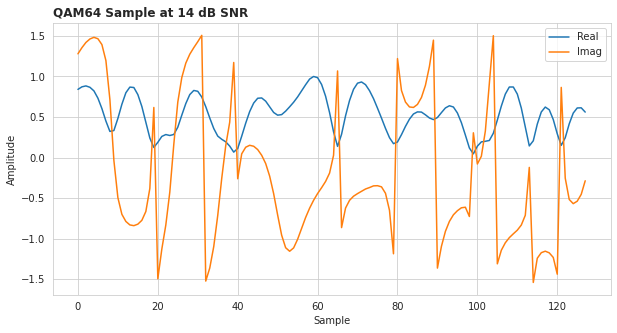

In [ ]:
fig_dir = None
import random

# Plot a sample of the data
# You can choose a different sample by changing
idx = random.randint(0, 200)
snr = 14
modulation = "QAM64"

mask = (train_Qams_high_snr.df["SNR"] == snr) & (train_Qams_high_snr.df["Modulation"] == modulation)
sample = train_Qams_high_snr.as_numpy(mask=mask, le=le_QAMs)[0][idx,0,:]

t = np.arange(sample.shape[1])

title = "{modulation} Sample at {snr:.0f} dB SNR".format(modulation=modulation, snr=snr)

# maxAmp = max(abs(sample[0,:]))
# sample[0,:] = sample[0,:] / maxAmp

fig = plot_IQ(iq=sample, title=title)
plt.show()


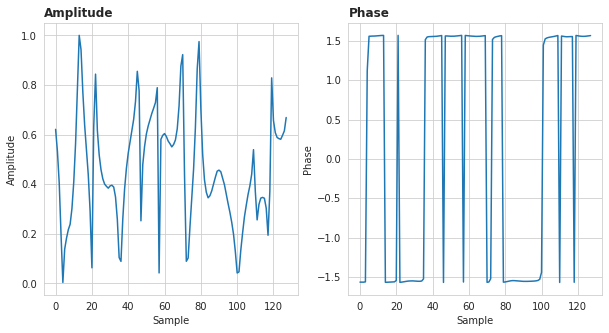

1.0


In [ ]:
# Amplitude & Phase
from matplotlib.figure import Figure
from typing import Iterable, List, Tuple

def plot_amp_phase(
    amp_phase: np.ndarray, figsize: Tuple[float, float] = (10.0, 5.0)
) -> Figure:
    """Plot IQ data in the time dimension.

    Args:
      iq (np.ndarray): Complex samples in a 2xN numpy array (IQ x Time)
      title (str, optional): Title to put above the plot. Defaults to None.
      figsize (Tuple[float, float], optional): Size of the figure to create.  Defaults
                                               to (10.0, 5.0).

    Raises:
        ValueError: If the amp_phase array is not 2xN

    Returns:
        [Figure]: Figure that the data was plotted onto (e.g. for saving plot)
    """
    if len(amp_phase.shape) != 2:
        raise ValueError("The amp_phase array must be complex (e.g. iq.shape=2xN).")
    if amp_phase.shape[0] != 2:
        raise ValueError(
            "The amp_phase array must be complex (e.g. iq.shape=2xN).  "
            "Your input did not have size 2 in dim 0."
        )

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    t = np.arange(amp_phase.shape[1])

    ax1.plot(t, amp_phase[0, :])
    ax1.set_xlabel("Sample")
    ax1.set_ylabel("Amplitude")
    ax1.set_title("Amplitude", loc="left", fontweight="bold")

    ax2.plot(t, amp_phase[1, :])
    ax2.set_xlabel("Sample")
    ax2.set_ylabel("Phase")
    ax2.set_title("Phase", loc="left", fontweight="bold")

    return fig

idx = random.randint(0, 200)
snr = 14
modulation = "QAM16"

mask = (train_Qams_high_snr.df["SNR"] == snr) & (train_Qams_high_snr.df["Modulation"] == modulation)
sample = train_Qams_high_snr.as_numpy(mask=mask, le=le_QAMs)[0][idx,0,:]

import math
amp_phase = np.zeros((2,128))
for iSample in range(128):
  currI = sample[0, iSample]
  currQ = sample[1, iSample]
  currAmp = math.sqrt(currI * currI + currQ * currQ)
  currPhase = np.arctan(currQ / currI)
  amp_phase[0, iSample] = currAmp
  amp_phase[1, iSample] = currPhase

maxAmp = max(abs(amp_phase[0,:]))
amp_phase[0,:] = amp_phase[0,:] / maxAmp
fig = plot_amp_phase(amp_phase=amp_phase)
plt.show()

print(max(amp_phase[0,:]))


# Model

In [13]:
class CNN1(Model):
    def __init__(self, input_samples: int, n_classes: int):
        super().__init__(input_samples=input_samples, n_classes=n_classes)
        # Batch x 1-channel x IQ x input_samples
        
        self.conv1 = nn.Conv2d(
            in_channels=1,
            out_channels=256,
            kernel_size=(1, 7),
            padding=(0, 3),
            bias=False,
        )
        self.a1 = nn.ReLU()
        self.n1 = nn.BatchNorm2d(256)

        self.conv2 = nn.Conv2d(
            in_channels=256,
            out_channels=80,
            kernel_size=(1, 7),
            padding=(0, 3),
            bias=True,
        )
        self.a2 = nn.ReLU()
        self.n2 = nn.BatchNorm2d(80)

        self.conv3 = nn.Conv2d(
            in_channels=80,
            out_channels=30,
            kernel_size=(2, 7),
            padding=(0, 3),
            bias=True,
        )

        self.a3 = nn.ReLU()
        self.n3 = nn.BatchNorm2d(30)

        # Batch x Features
        self.dense1 = nn.Linear(30 * 1 * input_samples, 256)
        self.a4 = nn.ReLU()
        self.n4 = nn.BatchNorm1d(256)

        self.dense2 = nn.Linear(256, n_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.a1(x)
        x = self.n1(x)

        x = self.conv2(x)
        x = self.a2(x)
        x = self.n2(x)

        x = self.conv3(x)
        x = self.a3(x)
        x = self.n3(x)

        # Flatten the input layer down to 1-d by using Tensor operations
        x = x.contiguous()
        x = x.view(x.size()[0], -1)

        x = self.dense1(x)
        x = self.a4(x)
        x = self.n4(x)

        x = self.dense2(x)

        return x

cnn1Model = CNN1(input_samples=128, n_classes=10)
print(cnn1Model) 

cldnnModel = CLDNN(input_samples = 128, n_classes = 2)
print(cldnnModel)

CNN1(
  (conv1): Conv2d(1, 256, kernel_size=(1, 7), stride=(1, 1), padding=(0, 3), bias=False)
  (a1): ReLU()
  (n1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(256, 80, kernel_size=(1, 7), stride=(1, 1), padding=(0, 3))
  (a2): ReLU()
  (n2): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(80, 30, kernel_size=(2, 7), stride=(1, 1), padding=(0, 3))
  (a3): ReLU()
  (n3): BatchNorm2d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dense1): Linear(in_features=3840, out_features=256, bias=True)
  (a4): ReLU()
  (n4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dense2): Linear(in_features=256, out_features=10, bias=True)
)
----------------------
Trainable Parameters: 1165972
Fixed Parameters: 0
Total Parameters: 1165972
----------------------

CLDNN(
  (conv1): Conv2d(1, 50, kernel_size=(1, 7), stride=(1, 1), padding=(0, 3)

# Training Functions

In [ ]:
class MyTrainingStrategy(object):

    def __init__(self, lr: float = 10e-4, n_epochs: int = 3, gpu: bool = True):
        self.lr = lr
        self.n_epochs = n_epochs
        self.gpu = gpu

    def __repr__(self):
        ret = self.__class__.__name__
        ret += "(lr={}, n_epochs={}, gpu={})".format(self.lr, self.n_epochs, self.gpu)
        return ret
        
    def __call__(
        self, model: nn.Module, training: Dataset, validation: Dataset, le: Encoder
    ):
        criterion = nn.CrossEntropyLoss()

        if self.gpu:
            model.cuda()
            criterion.cuda()

        optimizer = Adam(model.parameters(), lr=self.lr)

        train_data = DataLoader(
            training.as_torch(le=le), shuffle=True, batch_size=512
        )
        val_data = DataLoader(
            validation.as_torch(le=le), shuffle=True, batch_size=512
        )

        # Save two lists for plotting a convergence graph at the end
        ret_train_loss = list()
        ret_val_loss = list()
        
        for epoch in range(self.n_epochs):
            model, train_loss = self._train_one_epoch(model=model, data=train_data, loss_fn=criterion, optimizer=optimizer)

            print("On Epoch {} the training loss was {}".format(epoch, train_loss))
            ret_train_loss.append(train_loss)

            val_loss = self._validate_once(
                model=model, data=val_data, loss_fn=criterion
            )
            print("---- validation loss was {}".format(val_loss))
            ret_val_loss.append(val_loss)

        return model, ret_train_loss, ret_val_loss

    def _train_one_epoch(
        self, model: nn.Module, data: DataLoader, loss_fn: nn.CrossEntropyLoss, optimizer: Adam
    ) -> float:
        total_loss = 0.0
        # Switch the model mode so it remembers gradients, induces dropout, etc.
        model.train()

        for i, batch in enumerate(data):
            x, y = batch

            # Push data to GPU if necessary
            if self.gpu:
                x = Variable(x.cuda())
                y = Variable(y.cuda())
            else:
                x = Variable(x)
                y = Variable(y)

            # Forward pass of prediction
            outputs = model(x)

            # Zero out the parameter gradients, because they are cumulative,
            # compute loss, compute gradients (backward), update weights
            loss = loss_fn(outputs, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        mean_loss = total_loss / (i + 1.0)
        return model, mean_loss

    def _validate_once(
        self, model: nn.Module, data: DataLoader, loss_fn: nn.CrossEntropyLoss
    ) -> float:
        total_loss = 0.0
        # Switch the model back to test mode (so that batch norm/dropout doesn't
        # take effect)
        model.eval()
        for i, batch in enumerate(data):
            x, y = batch

            if self.gpu:
                x = x.cuda()
                y = y.cuda()

            outputs = model(x)
            loss = loss_fn(outputs, y)
            total_loss += loss.item()

        mean_loss = total_loss / (i + 1.0)
        return mean_loss

# ----------------------------------------------------------------- #
from datetime import datetime 
def save_model(model, dir_path, name):
  # create checkpints folder
  checkpoint_folder = os.path.join(dir_path, 'checkpoints')
  os.makedirs(checkpoint_folder, exist_ok=True)
  # save model
  curr_datetime = datetime.now().strftime("%y_%m_%d_%H:%M:%S")
  model_name = f'{curr_datetime}'.replace(':', '_')
  model_name = name + '_' + model_name
  
  ckpt_path = os.path.join(checkpoint_folder, f'{model_name}.ckpt')
  torch.save({
    'model_state_dict': model.state_dict(),
  }, ckpt_path)

  print(f'model saved to "{ckpt_path}"')

In [ ]:
# gpu = is_gpu_available
# trainer = MyTrainingStrategy(gpu=gpu, lr = 1e-4, n_epochs = 10)
# print(trainer)
# trainer.lr = 1e-5
# trainer.n_epochs = 5
# print(trainer)

MyTrainingStrategy(lr=1e-05, n_epochs=5, gpu=True)


# Train the network

## Train on all examples

In [ ]:
model_allSNR, train_loss_allSNR, val_loss_allSNR = trainer(model=model, training=train, validation=val, le=le)

On Epoch 0 the training loss was 0.9800630400699251
---- validation loss was 0.9515002362699394
On Epoch 1 the training loss was 0.9428590792276066
---- validation loss was 0.9544099856571979
On Epoch 2 the training loss was 0.9259567410231707
---- validation loss was 0.947456399360335


## Train By SNR groups

### High SNR (6 : 18[dB])

In [ ]:
gpu = is_gpu_available
trainer = MyTrainingStrategy(gpu=gpu, lr = 1e-3, n_epochs = 3)
model = CNN1(input_samples=128, n_classes=9)

# model = CLDNN(input_samples = 128, n_classes = 2)
model_highSNR, train_loss_highSNR, val_loss_highSNR = trainer(model=model, training=train_high_snr, validation=val_high_snr, le=le)



On Epoch 0 the training loss was 0.27968282923921123
---- validation loss was 0.17839274683903003
On Epoch 1 the training loss was 0.15270541241262858
---- validation loss was 0.15542696082386478
On Epoch 2 the training loss was 0.137597879333483
---- validation loss was 0.1324136452428226


### Medium SNR (-8 : 4 [dB])

In [ ]:
gpu = is_gpu_available
trainer = MyTrainingStrategy(gpu=gpu, lr = 1e-3, n_epochs = 3)
model = CNN1(input_samples=128, n_classes=9)
model_medSNR, train_loss_medSNR, val_loss_medSNR = trainer(model=model, training=train_med_snr, validation=val_med_snr, le=le)


On Epoch 0 the training loss was 0.6851444803314768
---- validation loss was 0.5676683978787784
On Epoch 1 the training loss was 0.5342769224346776
---- validation loss was 0.516485308778697
On Epoch 2 the training loss was 0.48310468747065616
---- validation loss was 0.48488483655041664


### Low SNR (-20 : - 10 [dB])

In [ ]:
gpu = is_gpu_available
trainer = MyTrainingStrategy(gpu=gpu, lr = 1e-3, n_epochs = 3)
model = CNN1(input_samples=128, n_classes=9)
model_lowSNR, train_loss_lowSNR, val_loss_lowSNR = trainer(model=model, training=train_low_snr, validation=val_low_snr, le=le)


On Epoch 0 the training loss was 1.9981072901660561
---- validation loss was 1.9680422306060792
On Epoch 1 the training loss was 1.9605328955202022
---- validation loss was 1.9635299634933472
On Epoch 2 the training loss was 1.9430925869024718
---- validation loss was 1.9692156553268432


## Train SEN

In [ ]:
sen_model = CNN1(input_samples=128, n_classes=snr_enc.n_classes)
sen_model, sen_train_loss, sen_val_loss = trainer(model=sen_model, training=train, validation=val, le=snr_enc)

On Epoch 0 the training loss was 0.24195163230088523
---- validation loss was 0.22038345685206265
On Epoch 1 the training loss was 0.20000389449637695
---- validation loss was 0.2166745964303074
On Epoch 2 the training loss was 0.19256177008381403
---- validation loss was 0.1886318839458098


## Train only QAMs

### High SNR (6 : 18[dB])

In [ ]:
gpu = is_gpu_available
trainer = MyTrainingStrategy(gpu=gpu, lr = 1e-4, n_epochs = 5)
qams_model = CLDNN(input_samples = 128, n_classes = 2)
qams_highSnr_model, qams_highSnr_train_loss, qams_highSnr_val_loss = trainer(model=qams_model, training=train_Qams_high_snr, validation=val_Qams_high_snr, le=le_QAMs)



On Epoch 0 the training loss was 0.23719214011322368
---- validation loss was 0.2640666713317235
On Epoch 1 the training loss was 0.23013702441345563
---- validation loss was 0.27591432879368466
On Epoch 2 the training loss was 0.22978705696084284
---- validation loss was 0.2762622262040774
On Epoch 3 the training loss was 0.22143171619285237
---- validation loss was 0.2583814511696498
On Epoch 4 the training loss was 0.21795579872348092
---- validation loss was 0.25528692454099655


### Medium SNR (-8 : 4 [dB])

In [ ]:
trainer = MyTrainingStrategy(gpu=gpu, lr = 1e-4, n_epochs = 5)

# qams_model = CLDNN(input_samples = 128, n_classes = 2)
# qams_medSNR_model, qams_medSNR_train_loss, qams_medSNR_val_loss = trainer(model=qams_model, training=train_Qams_med_snr, validation=val_Qams_med_snr, le=le_QAMs)

qams_medSNR_model, qams_medSNR_train_loss, qams_medSNR_val_loss = trainer(model=qams_medSNR_model, training=train_Qams_med_snr, validation=val_Qams_med_snr, le=le_QAMs)

On Epoch 0 the training loss was 0.46109636588530106
---- validation loss was 0.49410301943620044
On Epoch 1 the training loss was 0.4503911021080884
---- validation loss was 0.49098928769429523
On Epoch 2 the training loss was 0.4446296504952691
---- validation loss was 0.4881375928719838
On Epoch 3 the training loss was 0.4402692141858014
---- validation loss was 0.5000393986701965
On Epoch 4 the training loss was 0.4338469331914728
---- validation loss was 0.4950477381547292


### Low SNR (-20 : - 10 [dB])

In [ ]:
trainer = MyTrainingStrategy(gpu=gpu, lr = 5e-4, n_epochs = 10)

qams_model = CLDNN(input_samples = 128, n_classes = 2)
qams_lowSNR_model, qams_lowSNR_train_loss, qams_lowSNR_val_loss = trainer(model=qams_model, training=train_Qams_low_snr, validation=val_Qams_low_snr, le=le_QAMs)

# qams_lowSNR_model, qams_lowSNR_train_loss, qams_lowSNR_val_loss = trainer(model=qams_lowSNR_model, training=train_Qams_low_snr, validation=val_Qams_low_snr, le=le_QAMs)

On Epoch 0 the training loss was 0.6932313321752751
---- validation loss was 0.6727139592170716
On Epoch 1 the training loss was 0.6554869533853328
---- validation loss was 0.6544761180877685
On Epoch 2 the training loss was 0.6452489698186834
---- validation loss was 0.6482145309448242
On Epoch 3 the training loss was 0.636647178771648
---- validation loss was 0.6481655955314636
On Epoch 4 the training loss was 0.6281475348675505
---- validation loss was 0.64789297580719
On Epoch 5 the training loss was 0.6228869887108498
---- validation loss was 0.6562379002571106
On Epoch 6 the training loss was 0.6142263837317203
---- validation loss was 0.6585068106651306
On Epoch 7 the training loss was 0.6037272639731144
---- validation loss was 0.6613954186439515
On Epoch 8 the training loss was 0.5904121893517514
---- validation loss was 0.6756163001060486
On Epoch 9 the training loss was 0.5779227570016333
---- validation loss was 0.6802174091339112


## Plot results 

### All SNR's

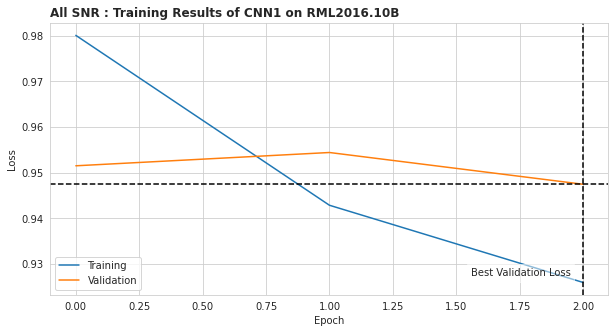

In [ ]:
title = "All SNR : Training Results of {model_name} on {dataset_name}".format(model_name="CNN1", dataset_name="RML2016.10B")
fig = plot_convergence(train_loss=train_loss_allSNR, val_loss=val_loss_allSNR, title=title)
if fig_dir is not None:
    file_path = "{fig_dir}/allSNR_training_loss.pdf"
    print("Saving Figure -> {file_path}".format(file_path=file_path))
    fig.savefig(file_path, format="pdf", transparent=True)
plt.show()

### High SNR

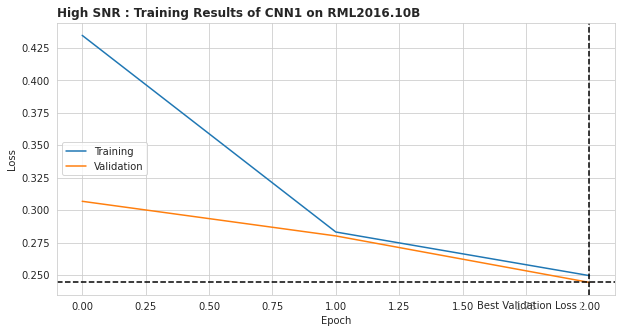

In [ ]:
title = "High SNR : Training Results of {model_name} on {dataset_name}".format(model_name="CNN1", dataset_name="RML2016.10B")
fig = plot_convergence(train_loss=train_loss_highSNR, val_loss=val_loss_highSNR, title=title)
if fig_dir is not None:
    file_path = "{fig_dir}/highSNR_training_loss.pdf"
    print("Saving Figure -> {file_path}".format(file_path=file_path))
    fig.savefig(file_path, format="pdf", transparent=True)
plt.show()

### Medium SNR

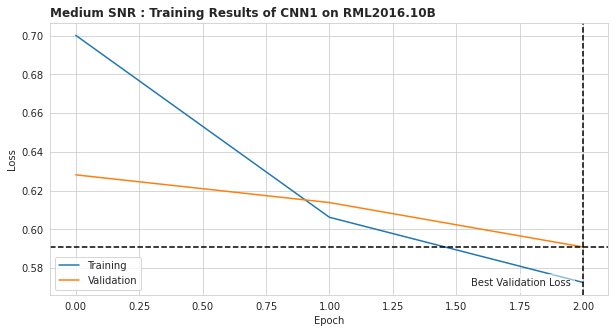

In [ ]:
title = "Medium SNR : Training Results of {model_name} on {dataset_name}".format(model_name="CNN1", dataset_name="RML2016.10B")
fig = plot_convergence(train_loss=train_loss_medSNR, val_loss=val_loss_medSNR, title=title)
if fig_dir is not None:
    file_path = "{fig_dir}/medSNR_training_loss.pdf"
    print("Saving Figure -> {file_path}".format(file_path=file_path))
    fig.savefig(file_path, format="pdf", transparent=True)
plt.show()

### Low SNR

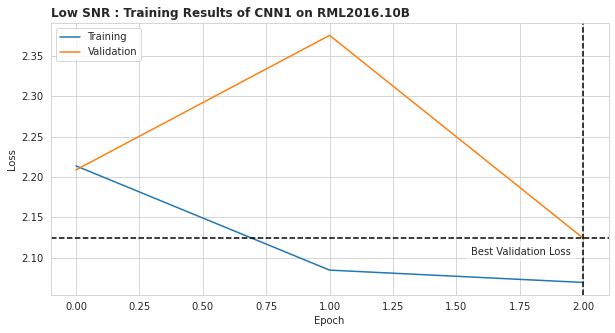

In [ ]:
title = "Low SNR : Training Results of {model_name} on {dataset_name}".format(model_name="CNN1", dataset_name="RML2016.10B")
fig = plot_convergence(train_loss=train_loss_lowSNR, val_loss=val_loss_lowSNR, title=title)
if fig_dir is not None:
    file_path = "{fig_dir}/lowSNR_training_loss.pdf"
    print("Saving Figure -> {file_path}".format(file_path=file_path))
    fig.savefig(file_path, format="pdf", transparent=True)
plt.show()

### SEN

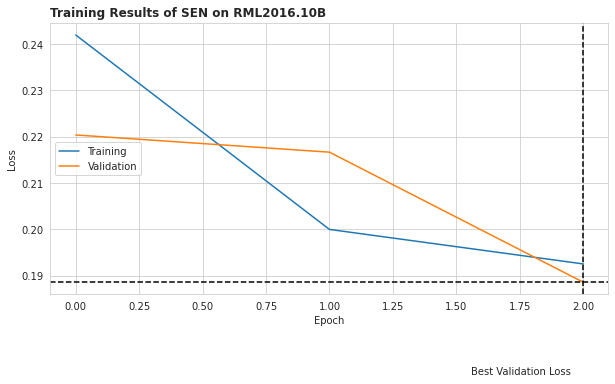

In [ ]:
title = "Training Results of {model_name} on {dataset_name}".format(model_name="SEN", dataset_name="RML2016.10B")
fig = plot_convergence(train_loss=sen_train_loss, val_loss=sen_val_loss, title=title)
plt.show()

# Save Model

In [ ]:
# # all SNR
# save_model(model_allSNR, drive_path, 'allSNR_CNN1_AMC_3_epochs')
# # High SNR
# save_model(model_highSNR, drive_path, 'highSNRSnr_CNN1_AMC_3_epochs')
# # medium SNR
# save_model(model_medSNR, drive_path, 'medSNR_CNN1_AMC_3_epochs')
# # low SNR 
# save_model(model_lowSNR, drive_path, 'lowSNR_CNN1_AMC_3_epochs')
# # SEN model
# save_model(sen_model, drive_path, 'SEN_CNN1_3_epochs')

# qams_path = drive_path + '/Qams/'
save_model(model_medSNR, drive_path, 'MediumSNR_MergedQams')



model saved to "/content/drive/MyDrive/Deep_learning_05107255/project/checkpoints/MediumSNR_MergedQams_22_09_03_08_06_50.ckpt"


# Load Pre-trained models

In [15]:
# ALL SNR
# allSNR_ckpt_path = f'{drive_path}/checkpoints/allSNR_CNN1_AMC_3_epochs_22_07.ckpt'
# allSNR_checkpoint = torch.load(allSNR_ckpt_path)
# model_allSNR = CNN1(input_samples=128, n_classes=10)
# model_allSNR.load_state_dict(allSNR_checkpoint['model_state_dict'])

# HIGH SNR
# highSNR_ckpt_path = f'{drive_path}/checkpoints/highSNR_CNN1_AMC_3_epochs_22_07.ckpt'
# highSNR_checkpoint = torch.load(highSNR_ckpt_path)
# model_highSNR = CNN1(input_samples=128, n_classes=10)
# model_highSNR.load_state_dict(highSNR_checkpoint['model_state_dict'])

# # MEDIUM SNR
# medSNR_ckpt_path = f'{drive_path}/checkpoints/medSNR_CNN1_AMC_3_epochs_22_07.ckpt'
# medSNR_checkpoint = torch.load(medSNR_ckpt_path)
# model_medSNR = CNN1(input_samples=128, n_classes=10)
# model_medSNR.load_state_dict(medSNR_checkpoint['model_state_dict'])

# # LOW SNR
# lowSNR_ckpt_path = f'{drive_path}/checkpoints/lowSNR_CNN1_AMC_3_epochs_22_07.ckpt'
# lowSNR_checkpoint = torch.load(lowSNR_ckpt_path)
# model_lowSNR = CNN1(input_samples=128, n_classes=10)
# model_lowSNR.load_state_dict(lowSNR_checkpoint['model_state_dict'])

# High SNR QAM
# QamhighSNR_ckpt_path = f'{drive_path}/checkpoints/qams_highSnr_lr_1e4_22_08_26_11_15_19.ckpt'
# QamhighSNR_checkpoint = torch.load(QamhighSNR_ckpt_path)
# Qam_model_highSNR = CLDNN(input_samples=128, n_classes=2)
# Qam_model_highSNR.load_state_dict(QamhighSNR_checkpoint['model_state_dict'])

# -----------------------------------------------------------------------------------------------------
# MERGED QAMS
# SEN
drive_path = '/content/drive/MyDrive/Deep_learning_05107255/project'
if is_gpu_available:
  map_location=torch.device('gpu')
else:
  map_location=torch.device('cpu')

sen_ckpt_path = f'{drive_path}/checkpoints/SEN_CNN1_3_epochs_22_08_19_11_54_37.ckpt'
sen_checkpoint = torch.load(sen_ckpt_path, map_location = map_location)
sen_model = CNN1(input_samples=128, n_classes=3)
sen_model.load_state_dict(sen_checkpoint['model_state_dict'])
# -----------------------------------------------------------------------------------------------------

#HIGH SNR
highSNR_ckpt_path = f'{drive_path}/checkpoints/Qams/highSNR_MergedQams_22_09_03_07_51_41.ckpt'
highSNR_checkpoint = torch.load(highSNR_ckpt_path, map_location = map_location)
model_highSNR = CNN1(input_samples=128, n_classes=9)
model_highSNR.load_state_dict(highSNR_checkpoint['model_state_dict'])

# # MEDIUM SNR
medSNR_ckpt_path = f'{drive_path}/checkpoints/Qams/MediumSNR_MergedQams_22_09_03_08_06_50.ckpt'
medSNR_checkpoint = torch.load(medSNR_ckpt_path, map_location = map_location)
model_medSNR = CNN1(input_samples=128, n_classes=9)
model_medSNR.load_state_dict(medSNR_checkpoint['model_state_dict'])

# # LOW SNR
lowSNR_ckpt_path = f'{drive_path}/checkpoints/Qams/LowSNR_MergedQams_22_09_03_08_06_25.ckpt'
lowSNR_checkpoint = torch.load(lowSNR_ckpt_path, map_location = map_location)
model_lowSNR = CNN1(input_samples=128, n_classes=9)
model_lowSNR.load_state_dict(lowSNR_checkpoint['model_state_dict'])

# ------------------------------------------------------------------------------------------------------------
# ONLY QAMS
# High SNR QAM
QamhighSNR_ckpt_path = f'{drive_path}/checkpoints/Qams/qams_highSNR_AmpPhase_22_09_01_19_06_12.ckpt'
QamhighSNR_checkpoint = torch.load(QamhighSNR_ckpt_path, map_location = map_location)
Qam_model_highSNR = CLDNN(input_samples=128, n_classes=2)
Qam_model_highSNR.load_state_dict(QamhighSNR_checkpoint['model_state_dict'])

# MED SNR QAM
QamMedSNR_ckpt_path = f'{drive_path}/checkpoints/Qams/qams_MedSNR_AmpPhase_22_09_01_19_15_29.ckpt'
QamMedSNR_checkpoint = torch.load(QamMedSNR_ckpt_path, map_location = map_location)
Qam_model_medSNR = CLDNN(input_samples=128, n_classes=2)
Qam_model_medSNR.load_state_dict(QamMedSNR_checkpoint['model_state_dict'])

# LOW SNR QAM
QamLowSNR_ckpt_path = f'{drive_path}/checkpoints/Qams/qams_lowSnr_lr_1e4_22_08_26_12_03_58.ckpt'
QamLowSNR_checkpoint = torch.load(QamLowSNR_ckpt_path, map_location = map_location)
Qam_model_lowSNR = CLDNN(input_samples=128, n_classes=2)
Qam_model_lowSNR.load_state_dict(QamLowSNR_checkpoint['model_state_dict'])

<All keys matched successfully>

# Test Models seperately

## Overall Accuracy

### All SNR

In [ ]:
acc = compute_accuracy(model=model_allSNR, data=test, le=le)
print("Overall Testing Accuracy: {:.4f}".format(acc))

Overall Testing Accuracy: 0.6330


### High SNR

In [ ]:
acc = compute_accuracy(model=model_highSNR, data=test_high_snr, le=le)
print("Overall Testing Accuracy: {:.4f}".format(acc))

Overall Testing Accuracy: 0.9028


### Medium SNR

In [ ]:
acc = compute_accuracy(model=model_medSNR, data=test_med_snr, le=le)
print("Overall Testing Accuracy: {:.4f}".format(acc))

Overall Testing Accuracy: 0.7374


### Low SNR

In [ ]:
acc = compute_accuracy(model=model_lowSNR, data=test_low_snr, le=le)
print("Overall Testing Accuracy: {:.4f}".format(acc))

Overall Testing Accuracy: 0.1946


### SEN

In [ ]:
sen_acc = compute_accuracy(model=sen_model, data=test, le=snr_enc)
print("Overall Testing Accuracy: {:.4f}".format(sen_acc))

Overall Testing Accuracy: 0.9250


## Accuracy vs SNR

### All SNR

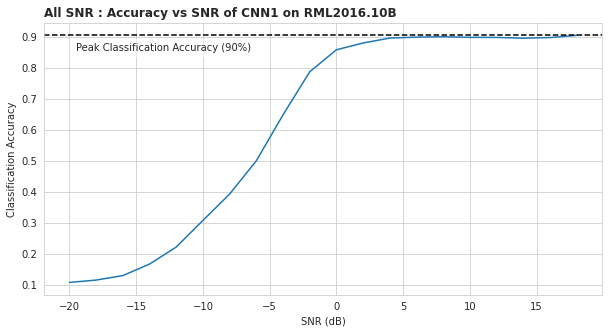

In [ ]:
acc_vs_snr, snr = compute_accuracy_on_cross_sections(model=model_allSNR,
                                                     data=test,
                                                     le=le,
                                                     column="SNR")

title = "All SNR : Accuracy vs SNR of {model_name} on {dataset_name}".format(model_name="CNN1", dataset_name="RML2016.10B")
fig = plot_acc_vs_snr(acc_vs_snr=acc_vs_snr, snr=snr, title=title)
if fig_dir is not None:
    file_path = "{fig_dir}/acc_vs_snr.pdf"
    print("Saving Figure -> {file_path}".format(file_path=file_path))
    fig.savefig(file_path, format="pdf", transparent=True)
plt.show()

### High SNR

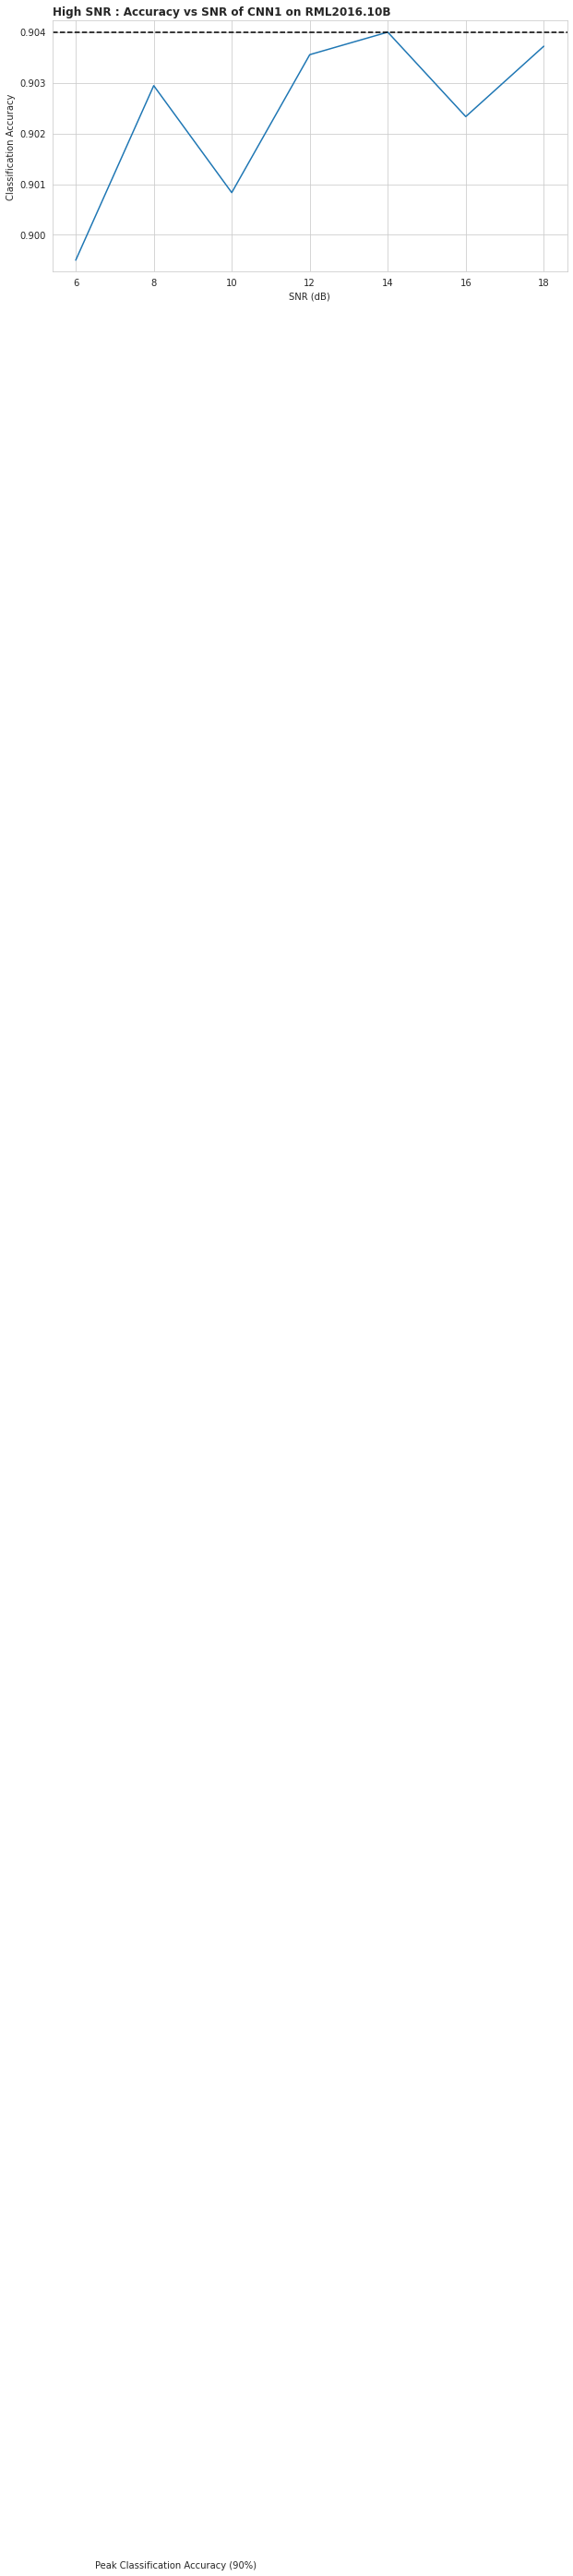

[10, 8, 12, 16, 14, 6, 18]


In [ ]:
acc_vs_snr, snr = compute_accuracy_on_cross_sections(model=model_highSNR,
                                                     data=test_high_snr,
                                                     le=le,
                                                     column="SNR")

title = "High SNR : Accuracy vs SNR of {model_name} on {dataset_name}".format(model_name="CNN1", dataset_name="RML2016.10B")
fig = plot_acc_vs_snr(acc_vs_snr=acc_vs_snr, snr=snr, title=title)
if fig_dir is not None:
    file_path = "{fig_dir}/highSNR_acc_vs_snr.pdf"
    print("Saving Figure -> {file_path}".format(file_path=file_path))
    fig.savefig(file_path, format="pdf", transparent=True)
plt.show()


### Medium SNR

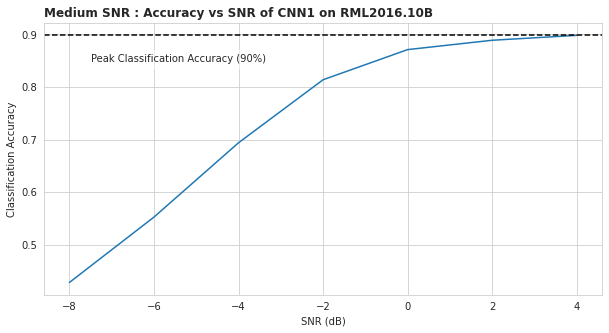

In [ ]:
acc_vs_snr, snr = compute_accuracy_on_cross_sections(model=model_medSNR,
                                                     data=test_med_snr,
                                                     le=le,
                                                     column="SNR")

title = "Medium SNR : Accuracy vs SNR of {model_name} on {dataset_name}".format(model_name="CNN1", dataset_name="RML2016.10B")
fig = plot_acc_vs_snr(acc_vs_snr=acc_vs_snr, snr=snr, title=title)
if fig_dir is not None:
    file_path = "{fig_dir}/medSNR_acc_vs_snr.pdf"
    print("Saving Figure -> {file_path}".format(file_path=file_path))
    fig.savefig(file_path, format="pdf", transparent=True)
plt.show()

### Low SNR

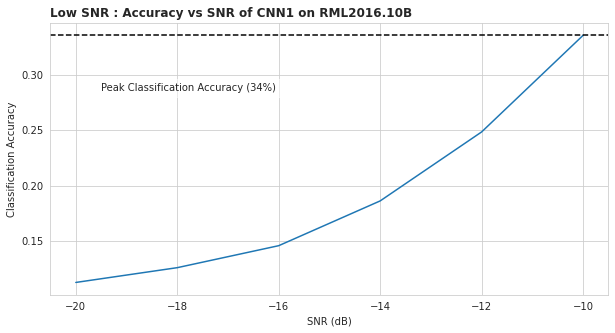

In [ ]:
acc_vs_snr, snr = compute_accuracy_on_cross_sections(model=model_lowSNR,
                                                     data=test_low_snr,
                                                     le=le,
                                                     column="SNR")

title = "Low SNR : Accuracy vs SNR of {model_name} on {dataset_name}".format(model_name="CNN1", dataset_name="RML2016.10B")
fig = plot_acc_vs_snr(acc_vs_snr=acc_vs_snr, snr=snr, title=title)
if fig_dir is not None:
    file_path = "{fig_dir}/lowSNR_acc_vs_snr.pdf"
    print("Saving Figure -> {file_path}".format(file_path=file_path))
    fig.savefig(file_path, format="pdf", transparent=True)
plt.show()

## Confusion matrix

In [41]:

# External Includes
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
from typing import List, Tuple

def convert_iq_to_ampPhase(input):
  iVec = input[:,:,0,:]
  qVec = input[:,:,1,:]
  iVecSquared = iVec * iVec
  qVecSquared = qVec * qVec

  ampVec = torch.sqrt(iVecSquared + qVecSquared)
  ampVec /= ampVec.max(2, keepdim=True)[0]

  divVec = qVec / iVec
  phaseVec = torch.atan(qVec / iVec)

  input[:,:,0,:] = ampVec
  input[:,:,1,:] = phaseVec

  return input


def compute_splitQams_confusion(
    mods_model: Model,
    qams_model: Model,
    data: Dataset,
    le: Encoder,
    batch_size: int = 512,
    mask: pd.DataFrame.mask = None,
) -> np.ndarray:
   
    predictions, labels = _extract_model_predictions_and_labels(mods_model=mods_model,
                                                                qams_model=qams_model,
                                                                data=data, le=le, batch_size=batch_size, mask=mask)
    
    return _confusion_matrix(predictions=predictions, labels=labels, le=le)


def _confusion_matrix(
    predictions: List[int], labels: List[int], le: Encoder
) -> np.ndarray:
    # Note: This could be replaced with sklearn.metrics.confusion_matrix
    # It is simply rewritten in order to avoid introducing a dependency for one thing
    confusion_matrix = np.zeros([len(le.labels), len(le.labels)])

    # Compute the total number of predictions
    for predicted_label, true_label in zip(predictions, labels):
        confusion_matrix[true_label, predicted_label] = (
            confusion_matrix[true_label, predicted_label] + 1.0
        )

    # Normalize these predictions to be a percentage
    for true_label in range(confusion_matrix.shape[0]):
        # Avoid a divide by zero case, no guarantee that we are calling this method
        # with data for all of the classes that could be predicted
        total = np.sum(confusion_matrix[true_label, :])

        if total == 0:
            confusion_matrix[true_label, :] = 0.0
        else:
            confusion_matrix[true_label, :] = confusion_matrix[true_label, :] / total

    return confusion_matrix


def _extract_model_predictions_and_labels(
    mods_model: Model,
    qams_model: Model,
    data: Dataset,
    le: Encoder,
    batch_size: int = 512,
    mask: pd.DataFrame.mask = None,
) -> Tuple[List[int], List[int]]:
    ret_predictions, ret_labels = list(), list()
    dl = DataLoader(
        data.as_torch(le=le, mask=mask), shuffle=True, batch_size=batch_size
    )
    batchNumber = 0
    for _, data in enumerate(dl):
        batchNumber += 1
        if(batchNumber % 10 == 0):
          print("Batch number : ", batchNumber, "/", 240)
          
        inputs, labels = data
        
        predictions = mods_model.predict(inputs)
        # ---------------------------------------------------------------------
        # Manipulation on QAMS
        qams_indx = (predictions == 8).nonzero(as_tuple=True)[0]
        if(len(qams_indx) > 0):
          # Take only qams
          qam_inputs  = inputs[qams_indx,  :, :, :]
          # Convert to amplitude & phase
          qam_inputs  = convert_iq_to_ampPhase(qam_inputs)
          # Predict 
          qam_pred =  qams_model.predict(qam_inputs)
          predictions[qams_indx] = qam_pred + 8
        # ---------------------------------------------------------------------

        ret_predictions.extend(predictions)
        ret_labels.extend(labels)

    return ret_predictions, ret_labels


### All SNR

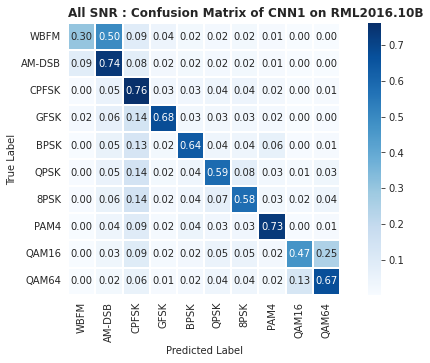

In [ ]:
cmn = compute_confusion(model=model_allSNR, data=test, le=le)

title = "All SNR : Confusion Matrix of {model_name} on {dataset_name}".format(model_name="CNN1", dataset_name="RML2016.10B")
fig = plot_confusion(cm=cmn, labels=le.labels, title=title)
if fig_dir is not None:
    file_path = "{fig_dir}/allSNR_confusion_matrix.pdf"
    print("Saving Figure -> {file_path}".format(file_path=file_path))
    fig.savefig(file_path, format="pdf", transparent=True)
plt.show()

### High SNR

In [43]:
# cmn = compute_confusion(model=model_highSNR, data=test_high_snr, le=le_mergedQams)
cmn = compute_splitQams_confusion(mods_model=model_highSNR, qams_model = Qam_model_highSNR, 
                                  data=test_high_snr, le=le)

title = "Confusion Matrix. High SNR"
fig = plot_confusion(cm=cmn, labels=le.labels, title=title)
plt.show()

Batch number :  10 / 240


KeyboardInterrupt: ignored

### Medium SNR

Batch number :  10 / 240
Batch number :  20 / 240
Batch number :  30 / 240
Batch number :  40 / 240
Batch number :  50 / 240
Batch number :  60 / 240
Batch number :  70 / 240
Batch number :  80 / 240
Batch number :  90 / 240
Batch number :  100 / 240
Batch number :  110 / 240
Batch number :  120 / 240
Batch number :  130 / 240
Batch number :  140 / 240
Batch number :  150 / 240
Batch number :  160 / 240
Batch number :  170 / 240
Batch number :  180 / 240
Batch number :  190 / 240
Batch number :  200 / 240
Batch number :  210 / 240
Batch number :  220 / 240
Batch number :  230 / 240
Batch number :  240 / 240


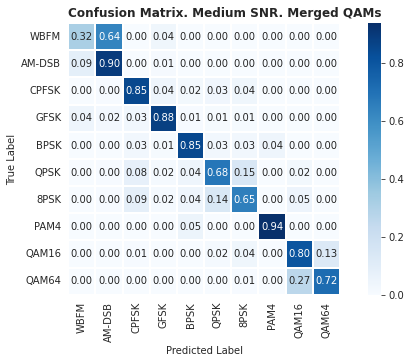

In [45]:
# cmn = compute_confusion(model=model_medSNR, data=test_med_snr, le=le)
cmn = compute_splitQams_confusion(mods_model=model_medSNR, qams_model = Qam_model_medSNR, 
                                  data=test_med_snr, le=le)
title = "Confusion Matrix. Medium SNR. Merged QAMs"
fig = plot_confusion(cm=cmn, labels=le.labels, title=title)
plt.show()

### Low SNR

Batch number :  10 / 240
Batch number :  20 / 240
Batch number :  30 / 240
Batch number :  40 / 240
Batch number :  50 / 240
Batch number :  60 / 240
Batch number :  70 / 240
Batch number :  80 / 240
Batch number :  90 / 240
Batch number :  100 / 240
Batch number :  110 / 240
Batch number :  120 / 240
Batch number :  130 / 240
Batch number :  140 / 240
Batch number :  150 / 240
Batch number :  160 / 240
Batch number :  170 / 240
Batch number :  180 / 240
Batch number :  190 / 240
Batch number :  200 / 240
Batch number :  210 / 240


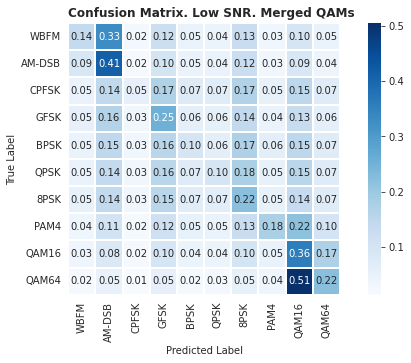

In [47]:
# cmn = compute_confusion(model=model_lowSNR, data=test_low_snr, le=le)
cmn = compute_splitQams_confusion(mods_model=model_lowSNR, qams_model = Qam_model_lowSNR, 
                                  data=test_low_snr, le=le)
title = "Confusion Matrix. Low SNR. Merged QAMs"
fig = plot_confusion(cm=cmn, labels=le.labels, title=title)
plt.show()

### SEN

[-20,-10]
[-8,4]
[6,18]
[-20,-10]
[-8,4]
[6,18]
[-20,-10]
[-8,4]
[6,18]


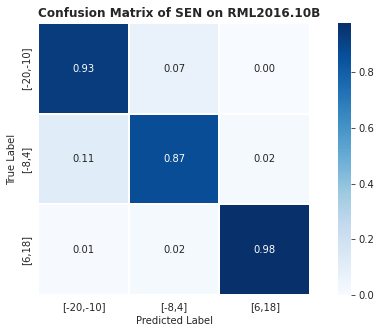

In [ ]:
sen_cmn = compute_confusion(model=sen_model, data=test, le=snr_enc)
title = "Confusion Matrix of {model_name} on {dataset_name}".format(model_name="SEN", dataset_name="RML2016.10B")
fig = plot_confusion(cm=sen_cmn, labels=snr_enc.labels, title=title)
if fig_dir is not None:
    file_path = "{fig_dir}/sen_confusion_matrix.pdf"
    print("Saving Figure -> {file_path}".format(file_path=file_path))
    fig.savefig(file_path, format="pdf", transparent=True)

plt.show()

### QAMs High SNR

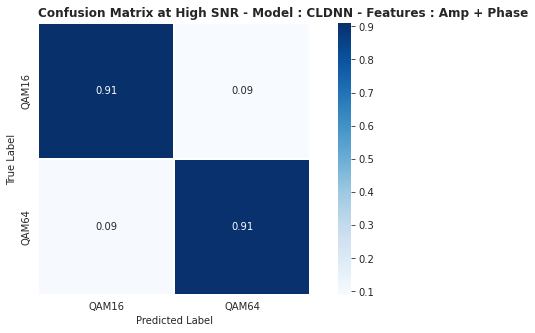

In [ ]:
qams_cmn = compute_confusion(model=Qam_model_highSNR, data=test_Qams_high_snr, le=le_QAMs)
#title = "CLDNN Confusion Matrix of High SNR {model_name} on {dataset_name}".format(model_name="QAMs", dataset_name="RML2016.10B")
title = "Confusion Matrix at High SNR - Model : CLDNN - Features : Amp + Phase"
fig = plot_confusion(cm=qams_cmn, labels=le_QAMs.labels, title=title)
plt.show()

### QAMs Medium SNR

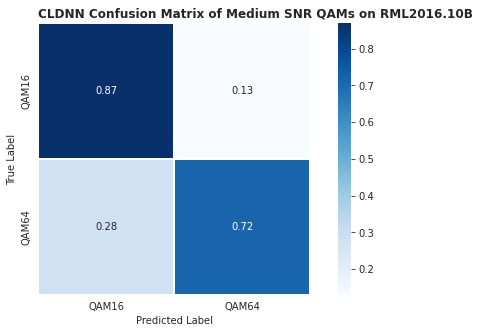

In [ ]:
qams_cmn = compute_confusion(model=Qam_model_medSNR, data=test_Qams_med_snr, le=le_QAMs)
title = "CLDNN Confusion Matrix of Medium SNR {model_name} on {dataset_name}".format(model_name="QAMs", dataset_name="RML2016.10B")
fig = plot_confusion(cm=qams_cmn, labels=le_QAMs.labels, title=title)
plt.show()

### QAMs Low SNR

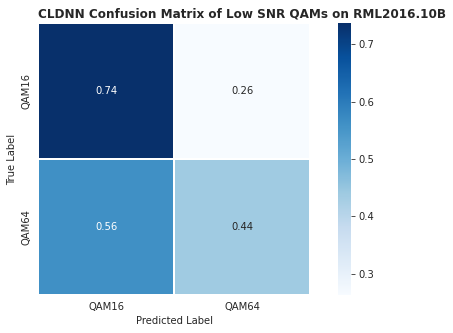

In [ ]:
qams_cmn = compute_confusion(model=qams_lowSNR_model, data=test_Qams_low_snr, le=le_QAMs)
title = "CLDNN Confusion Matrix of Low SNR {model_name} on {dataset_name}".format(model_name="QAMs", dataset_name="RML2016.10B")
fig = plot_confusion(cm=qams_cmn, labels=le_QAMs.labels, title=title)
plt.show()

# Test Cascaded SNR - Modulation Models

## Compute Accuracy

In [ ]:
import pandas as pd

def compute_cascaded_sen_amc_accuracy(
    sen_model: Model,
    high_snr_model: Model,
    med_snr_model: Model,
    low_snr_model: Model,
    data: Dataset,
    le: Encoder,
    batch_size: int = 512,
    mask: pd.DataFrame.mask = None,
) -> float:
    """Compute the Top-1 accuracy of this cascading SEN & AMC Models

    Args:
        senModel (senModel): (Trained) SEN model.
        highSNRModel (highSNRModel): (Trained) model to on high SNR.
        medSNRModel (medSNRModel): (Trained) model to on high SNR.
        lowSNRModel (lowSNRModel): (Trained) model to on high SNR.
        data (Dataset): (Testing) data to use for evaluation.
        le (Encoder): Mapping from human readable to machine readable.
        batch_size (int, optional): Defaults to 512.
        mask (pd.DataFrame.mask, optional): Mask to apply to the data before computing
                                            accuracy.  Defaults to None.

    Returns:
        float: Top-1 Accuracy - All SNR
        float: Top-1 Accuracy - High SNR
        float: Top-1 Accuracy - Med SNR
        float: Top-1 Accuracy - Low SNR
        
    """
    
    dl = DataLoader(
        data.as_torch(le=le, mask=mask), shuffle=True, batch_size=batch_size
    )

    rightLowSNR = 0
    rightMedSNR = 0
    rightHighSNR = 0
    
    nExamplesLowSNR = 0
    nExamplesMedSNR = 0
    nExamplesHighSNR = 0

    for _, data in enumerate(dl):
        inputs, labels = data
        # SNR estimation
        snr_predictions = sen_model.predict(inputs)
        # Divide according to SNR Estimation
        low_snr_indx =  (snr_predictions == 0).nonzero(as_tuple=True)[0]
        med_snr_indx =  (snr_predictions == 1).nonzero(as_tuple=True)[0]
        high_snr_indx = (snr_predictions == 2).nonzero(as_tuple=True)[0]
        
        if(len(low_snr_indx) > 0):
          low_snr_inputs  = inputs[low_snr_indx,  :, :, :]
          low_snr_labels =  labels[low_snr_indx]
          low_snr_pred =  low_snr_model.predict(low_snr_inputs)
          rightLowSNR += (low_snr_pred == low_snr_labels).sum().item()
          nExamplesLowSNR += len(low_snr_labels)

        if(len(med_snr_indx) > 0):  
          med_snr_inputs  = inputs[med_snr_indx,  :, :, :]
          med_snr_labels =  labels[med_snr_indx]
          med_snr_pred =  med_snr_model.predict(med_snr_inputs)
          rightMedSNR += (med_snr_pred == med_snr_labels).sum().item()
          nExamplesMedSNR += len(med_snr_labels)

        if(len(high_snr_indx) > 0):
          high_snr_inputs = inputs[high_snr_indx, :, :, :]
          high_snr_labels = labels[high_snr_indx]
          high_snr_pred = high_snr_model.predict(high_snr_inputs)
          rightHighSNR += (high_snr_pred == high_snr_labels).sum().item()
          nExamplesHighSNR += len(high_snr_labels)
    
    accLow = float(rightLowSNR) / nExamplesLowSNR
    accMed = float(rightMedSNR) / nExamplesMedSNR
    accHigh = float(rightHighSNR) / nExamplesHighSNR
    
    totalRight = rightLowSNR + rightMedSNR + rightHighSNR
    nTotalExamples = nExamplesLowSNR + nExamplesMedSNR + nExamplesHighSNR
    accAll = float(totalRight) / nTotalExamples
    
    return accAll, accHigh, accMed, accLow

In [ ]:
accAll, accHigh, accMed, accLow = compute_cascaded_sen_amc_accuracy(sen_model=sen_model, 
                                                                    high_snr_model = model_highSNR,
                                                                    med_snr_model = model_medSNR,
                                                                    low_snr_model = model_lowSNR,
                                                                    data=test, le=le)
print('ACC LOW : ', accLow)
print('ACC MED : ', accMed)
print('ACC HIGH : ', accHigh)
print('ACC ALL : ', accAll)

KeyboardInterrupt: ignored

## Confusion Matrix

In [ ]:

# External Includes
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
from typing import List, Tuple

def compute_cascadedModel_confusion(
    sen_model: Model,
    high_snr_model: Model,
    med_snr_model: Model,
    low_snr_model: Model,
    data: Dataset,
    le: Encoder,
    batch_size: int = 512,
    mask: pd.DataFrame.mask = None,
) -> np.ndarray:
   
    predictions, labels = _extract_cascaded_model_predictions_and_labels(sen_model=sen_model, high_snr_model=high_snr_model,
                                                                         med_snr_model=med_snr_model, low_snr_model=low_snr_model,
                                                                         data=data, le=le, batch_size=batch_size, mask=mask)
    return _confusion_matrix(predictions=predictions, labels=labels, le=le)


def _confusion_matrix(
    predictions: List[int], labels: List[int], le: Encoder
) -> np.ndarray:
    # Note: This could be replaced with sklearn.metrics.confusion_matrix
    # It is simply rewritten in order to avoid introducing a dependency for one thing
    confusion_matrix = np.zeros([len(le.labels), len(le.labels)])

    # Compute the total number of predictions
    for predicted_label, true_label in zip(predictions, labels):
        confusion_matrix[true_label, predicted_label] = (
            confusion_matrix[true_label, predicted_label] + 1.0
        )

    # Normalize these predictions to be a percentage
    for true_label in range(confusion_matrix.shape[0]):
        # Avoid a divide by zero case, no guarantee that we are calling this method
        # with data for all of the classes that could be predicted
        total = np.sum(confusion_matrix[true_label, :])

        if total == 0:
            confusion_matrix[true_label, :] = 0.0
        else:
            confusion_matrix[true_label, :] = confusion_matrix[true_label, :] / total

    return confusion_matrix


def _extract_cascaded_model_predictions_and_labels(
    sen_model: Model,
    high_snr_model: Model,
    med_snr_model: Model,
    low_snr_model: Model,
    data: Dataset,
    le: Encoder,
    batch_size: int = 512,
    mask: pd.DataFrame.mask = None,
) -> Tuple[List[int], List[int]]:
    ret_predictions, ret_labels = list(), list()
    dl = DataLoader(
        data.as_torch(le=le, mask=mask), shuffle=True, batch_size=batch_size
    )

    for _, data in enumerate(dl):
        inputs, labels = data

        # SNR estimation
        snr_predictions = sen_model.predict(inputs)
        # Divide according to SNR Estimation
        low_snr_indx =  (snr_predictions == 0).nonzero(as_tuple=True)[0]
        med_snr_indx =  (snr_predictions == 1).nonzero(as_tuple=True)[0]
        high_snr_indx = (snr_predictions == 2).nonzero(as_tuple=True)[0]
        
        if(len(low_snr_indx) > 0):
          low_snr_inputs  = inputs[low_snr_indx,  :, :, :]
          low_snr_pred =  low_snr_model.predict(low_snr_inputs)

        if(len(med_snr_indx) > 0):  
          med_snr_inputs  = inputs[med_snr_indx,  :, :, :]
          med_snr_pred =  med_snr_model.predict(med_snr_inputs)

        if(len(high_snr_indx) > 0):
          high_snr_inputs = inputs[high_snr_indx, :, :, :]
          high_snr_pred = high_snr_model.predict(high_snr_inputs)

        # Merge all predictions
        predictions = torch.tensor(np.zeros(batch_size, dtype=int))
        predictions[low_snr_indx]  = low_snr_pred
        predictions[med_snr_indx]  = med_snr_pred
        predictions[high_snr_indx] = high_snr_pred

        ret_predictions.extend(predictions)
        ret_labels.extend(labels)

    return ret_predictions, ret_labels


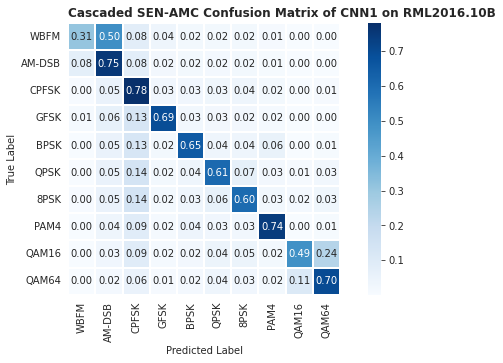

In [ ]:
cmn = compute_cascadedModel_confusion(sen_model=sen_model, high_snr_model = model_highSNR,
                                      med_snr_model = model_medSNR, low_snr_model = model_lowSNR,
                                      data=test, le=le)

title = "Cascaded SEN-AMC Confusion Matrix of {model_name} on {dataset_name}".format(model_name="CNN1", dataset_name="RML2016.10B")
fig = plot_confusion(cm=cmn, labels=le.labels, title=title)
plt.show()

# Test Cascaded SNR - QAM

## Function - Compute Acc

In [ ]:
import pandas as pd

def compute_cascaded_sen_qam_accuracy(
    sen_model: Model,
    high_snr_model: Model,
    med_snr_model: Model,
    low_snr_model: Model,
    high_qam_model : Model,
    med_qam_model : Model,
    low_qam_model : Model,
    data: Dataset,
    le: Encoder,
    batch_size: int = 512,
    mask: pd.DataFrame.mask = None,
) -> float:
    """Compute the Top-1 accuracy of this cascading SEN & AMC Models

    Args:
        senModel (senModel): (Trained) SEN model.
        highSNRModel (highSNRModel): (Trained) model to on high SNR.
        medSNRModel (medSNRModel): (Trained) model to on high SNR.
        lowSNRModel (lowSNRModel): (Trained) model to on high SNR.
        data (Dataset): (Testing) data to use for evaluation.
        le (Encoder): Mapping from human readable to machine readable.
        batch_size (int, optional): Defaults to 512.
        mask (pd.DataFrame.mask, optional): Mask to apply to the data before computing
                                            accuracy.  Defaults to None.

    Returns:
        float: Top-1 Accuracy - All SNR
        float: Top-1 Accuracy - High SNR
        float: Top-1 Accuracy - Med SNR
        float: Top-1 Accuracy - Low SNR
        
    """
    
    dl = DataLoader(
        data.as_torch(le=le, mask=mask), shuffle=True, batch_size=batch_size
    )

    rightLowSNR = 0
    rightMedSNR = 0
    rightHighSNR = 0
    
    nExamplesLowSNR = 0
    nExamplesMedSNR = 0
    nExamplesHighSNR = 0
    # -----------------------------------------
    # Debug
    iterationsCounter = 0
    numQams = 0
    numCorrectQams = 0

    for _, data in enumerate(dl):
        iterationsCounter += 1
        inputs, labels = data
        # ------------------------------------------------------------------------------
        # SNR estimation
        snr_predictions = sen_model.predict(inputs)
        # Divide according to SNR Estimation
        low_snr_indx =  (snr_predictions == 0).nonzero(as_tuple=True)[0]
        med_snr_indx =  (snr_predictions == 1).nonzero(as_tuple=True)[0]
        high_snr_indx = (snr_predictions == 2).nonzero(as_tuple=True)[0]
        # ------------------------------------------------------------------------------
        # Low SNR
        if(len(low_snr_indx) > 0):
          low_snr_inputs  = inputs[low_snr_indx,  :, :, :]
          low_snr_labels =  labels[low_snr_indx]
          low_snr_pred =  low_snr_model.predict(low_snr_inputs)

          qams_indx = (low_snr_pred == 8).nonzero(as_tuple=True)[0]

          nonQam_indx = (low_snr_pred < 8).nonzero(as_tuple=True)[0]
          # ------------------------------------------------------------------------------
          # QAM
          if(len(qams_indx) > 0):
            qam_inputs  = low_snr_inputs[qams_indx,  :, :, :]
            qam_labels =  low_snr_labels[qams_indx]
            qam_pred =  low_qam_model.predict(qam_inputs)
            rightLowSNR += (qam_pred == qam_labels-8).sum().item()
          # ------------------------------------------------------------------------------
          # Non QAM
          if(len(nonQam_indx) > 0):   
            nonqam_labels = low_snr_labels[nonQam_indx]
            nonqam_pred = low_snr_pred[nonQam_indx]  
            rightLowSNR += (nonqam_pred == nonqam_labels).sum().item()  
          # ------------------------------------------------------------------------------
          nExamplesLowSNR += len(low_snr_labels)
        # ------------------------------------------------------------------------------
        # Medium SNR
        if(len(med_snr_indx) > 0):  
          med_snr_inputs  = inputs[med_snr_indx,  :, :, :]
          med_snr_labels =  labels[med_snr_indx]
          med_snr_pred =  med_snr_model.predict(med_snr_inputs)
          
          qams_indx = (med_snr_pred == 8).nonzero(as_tuple=True)[0]
          nonQam_indx = (med_snr_pred < 8).nonzero(as_tuple=True)[0]
          # ------------------------------------------------------------------------------
          # QAM
          if(len(qams_indx) > 0):
            qam_inputs  = med_snr_inputs[qams_indx,  :, :, :]
            qam_labels =  med_snr_labels[qams_indx]
            qam_pred =  med_qam_model.predict(qam_inputs)
            rightMedSNR += (qam_pred == qam_labels-8).sum().item()
          # ------------------------------------------------------------------------------
          # Non QAM
          if(len(nonQam_indx) > 0):   
            nonqam_labels = med_snr_labels[nonQam_indx]
            nonqam_pred = med_snr_pred[nonQam_indx]  
            rightMedSNR += (nonqam_pred == nonqam_labels).sum().item()  
          # ------------------------------------------------------------------------------
          nExamplesMedSNR += len(med_snr_labels)
        # ------------------------------------------------------------------------------
        # High SNR
        if(len(high_snr_indx) > 0):
          high_snr_inputs = inputs[high_snr_indx, :, :, :]
          high_snr_labels = labels[high_snr_indx]
          high_snr_pred = high_snr_model.predict(high_snr_inputs)
          
          qams_indx = (high_snr_pred == 8).nonzero(as_tuple=True)[0]
          numQams += len(qams_indx)
          nonQam_indx = (high_snr_pred < 8).nonzero(as_tuple=True)[0]

          # ------------------------------------------------------------------------------
          # QAM
          if(len(qams_indx) > 0):
            qam_inputs  = high_snr_inputs[qams_indx,  :, :, :]
            qam_labels =  high_snr_labels[qams_indx]
            qam_pred =  high_qam_model.predict(qam_inputs)
            numCorrectQams += (qam_pred == qam_labels-8).sum().item()
            rightHighSNR += (qam_pred == qam_labels-8).sum().item()
          # ------------------------------------------------------------------------------
          # Non QAM
          if(len(nonQam_indx) > 0):   
            nonqam_labels = high_snr_labels[nonQam_indx]
            nonqam_pred = high_snr_pred[nonQam_indx]  
            rightHighSNR += (nonqam_pred == nonqam_labels).sum().item()  
          # ------------------------------------------------------------------------------
          nExamplesHighSNR += len(high_snr_labels)
        # ------------------------------------------------------------------------------

        if(iterationsCounter % 10 == 0):
          print(iterationsCounter)
          print("CurrAccLow : ", float(rightLowSNR) / nExamplesLowSNR)
          print("CurrAccMed : ", float(rightMedSNR) / nExamplesMedSNR)
          print("CurrAccHigh : ", float(rightHighSNR) / nExamplesHighSNR)
          print("Num Qams High SNR: ", numQams)
          print("Num correct Qams High SNR: ", numCorrectQams)

    accLow = float(rightLowSNR) / nExamplesLowSNR
    accMed = float(rightMedSNR) / nExamplesMedSNR
    accHigh = float(rightHighSNR) / nExamplesHighSNR
    
    totalRight = rightLowSNR + rightMedSNR + rightHighSNR
    nTotalExamples = nExamplesLowSNR + nExamplesMedSNR + nExamplesHighSNR
    accAll = float(totalRight) / nTotalExamples
    
    return accAll, accHigh, accMed, accLow

## Run on Test

In [ ]:
accAll, accHigh, accMed, accLow = compute_cascaded_sen_qam_accuracy(sen_model=sen_model, 
                                                                    high_snr_model = model_highSNR,
                                                                    med_snr_model = model_medSNR,
                                                                    low_snr_model = model_lowSNR,
                                                                    high_qam_model = Qam_model_highSNR,
                                                                    med_qam_model = Qam_model_medSNR,
                                                                    low_qam_model = Qam_model_lowSNR,
                                                                    data=test, le=le)
print('ACC LOW : ', accLow)
print('ACC MED : ', accMed)
print('ACC HIGH : ', accHigh)
print('ACC ALL : ', accAll)


In [37]:
a = torch.randn(3,1,2,4)
iVec = a[:,:,0,:]
qVec = a[:,:,1,:]
iVecSquared = iVec * iVec
qVecSquared = qVec * qVec

ampVec = torch.sqrt(iVecSquared + qVecSquared)
ampVec /= ampVec.max(2, keepdim=True)[0]

divVec = qVec / iVec
phaseVec = torch.atan(qVec / iVec)


print(iVec)
print(qVec)
print(phaseVec)

tensor([[[ 1.4772, -0.5325, -1.6990,  1.5967]],

        [[-1.4157,  0.0093,  0.7210, -0.1580]],

        [[-1.0857, -1.2687, -0.0195,  0.1351]]])
tensor([[[ 0.4882,  0.1331,  1.8309,  1.3442]],

        [[-1.2477, -2.3231,  0.6336,  1.1394]],

        [[-1.1971, -0.6491,  0.9368,  0.0662]]])
tensor([[[ 0.3192, -0.2450, -0.8227,  0.6998]],

        [[ 0.7224, -1.5668,  0.7210, -1.4330]],

        [[ 0.8342,  0.4729, -1.5500,  0.4556]]])
